## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_exp as sg




### <font style="color:lightblue">Redefine</font>

In [ ]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [ ]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**6
    ,batchSplit = 2**0
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateG = 1e-3
    ,learningRateD = 1e-3
    ,dataDir = 'data'
)

sg.DCfg = sg.DCfgClass(16,True)


#os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [ ]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, expose = 1e-5)
sg.trainLoader = sg.createDataLoader(sg.trainSet, num_workers=sg.TCfg.num_workers)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive = True)
sg.testLoader = sg.createDataLoader(sg.testSet, num_workers=sg.TCfg.num_workers)

### <font style="color:lightblue">Show</font>

In [ ]:
sg.examples = [
    ((3, 476, 2880), 0.78),
    ((2, 118,  988), 0.89),
    ((0, 336, 645), 0.725),
    #((0, 298, 1557), 0.846),
    ((3, 925,  592), 0.35)
    #(0, 0, 360, 2108)
    #(0, 0, 338, 773)
    #(0, 0, 411, 1169)
]

sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
#sg.showMe(sg.testSet)
#sg.displayImages()


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [ ]:
def unrollArch2(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator2(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator2, self).__init__(2, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = None
        self.baseChannels = 64
        unrollArch2(self)
        #sg.load_model(self, model_path="saves/aio/models/dbricks2.pt" )





### Generator 4pix

In [ ]:
def unrollArch4(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        gen.encblock(  8, 8, 3),
        gen.encblock(  8,16, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(32, 8, 3, stride=2),
        gen.decblock(16, 8, 3),
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator4(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator4, self).__init__(4, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = DBricksGenerator2()
        self.baseChannels = 64
        unrollArch4(self)

#generator = DBricksGenerator4()
#generator.requires_grad_(False)
#generator.lowResGenerator.requires_grad_(False)
#generator.lowResGenerator.eval()
#generator = generator.to(sg.TCfg.device)
#
#model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#print(model_summary)




### Generator 8pix

In [ ]:
def unrollArch8(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1, 2, 3, stride=2),
        gen.encblock(  2, 2, 3),
        gen.encblock(  2, 4, 3, stride=2),
        gen.encblock(  4, 4, 3),
        gen.encblock(  4, 8, 3, stride=2),
        gen.encblock(  8, 8, 3),
        gen.encblock(  8,16, 3, stride=2),
        gen.encblock( 16,16, 3),
        gen.encblock( 16,32, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(64,16, 3, stride=2),
        gen.decblock(32,16, 3),
        gen.decblock(32, 8, 3, stride=2),
        gen.decblock(16, 8, 3),
        gen.decblock(16, 4, 3, stride=2),
        gen.decblock( 8, 4, 3),
        gen.decblock( 8, 2, 3, stride=2),
        gen.decblock( 4, 2, 3),
        gen.decblock( 4, 1, 3, stride=2),
        gen.decblock( 2, 1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator8(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator8, self).__init__(8, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = DBricksGenerator4()
        self.baseChannels = 64
        unrollArch8(self)
        sg.load_model(self, model_path="saves/aio/models/dbricks8.pt" )



#generator = DBricksGenerator8()
#generator = generator.to(sg.TCfg.device)
#
#
#model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#print(model_summary)
#
#sg.generator = generator




### Generator 16pix

In [110]:
def unrollArch16(gen) :
    gen.encoders =  nn.ModuleList([
        gen.encblock( gen.inChannels/gen.baseChannels,
                           1, 3, norm=False),
        gen.encblock(  1,  2, 3, stride=2),
        gen.encblock(  2,  2, 3),
        gen.encblock(  2,  4, 3, stride=2),
        gen.encblock(  4,  4, 3),
        gen.encblock(  4,  8, 3, stride=2),
        gen.encblock(  8,  8, 3),
        gen.encblock(  8, 16, 3, stride=2),
        gen.encblock( 16, 16, 3),
        gen.encblock( 16, 32, 3, stride=2),
        gen.encblock( 32, 32, 3),
        gen.encblock( 32, 64, 3, stride=2),
        ])
    gen.fcLink = gen.createFClink()
    gen.decoders = nn.ModuleList([
        gen.decblock(128, 32, 3, stride=2),
        gen.decblock( 64, 32, 3),
        gen.decblock( 64, 16, 3, stride=2),
        gen.decblock( 32, 16, 3),
        gen.decblock( 32,  8, 3, stride=2),
        gen.decblock( 16,  8, 3),
        gen.decblock( 16,  4, 3, stride=2),
        gen.decblock(  8,  4, 3),
        gen.decblock(  8,  2, 3, stride=2),
        gen.decblock(  4,  2, 3),
        gen.decblock(  4,  1, 3, stride=2),
        gen.decblock(  2,  1, 3, norm=False),
        ])
    gen.lastTouch = gen.createLastTouch()
    #return gen


class DBricksGenerator16(sg.SubGeneratorTemplate) :
    def __init__(self):
        super(DBricksGenerator16, self).__init__(16, True, batchNorm=True, inChannels=2)
        self.lowResGenerator = DBricksGenerator8()
        self.baseChannels = 64
        unrollArch16(self)
        sg.load_model(self, model_path="tmp2.pt" )

generator = DBricksGenerator16()

generator.requires_grad_(False)
for param in generator.parameters() :
    #torch.nn.init.normal_(param, mean=1.0, std=0.01)
    param *= torch.randn_like(param)*0.01 + 1.0


#generator.requires_grad_(False)
#from itertools import islice
#def reuseLowResWeights(genP, genL) :
#    nofL = sum(1 for dummy in genL.decoders.parameters())
#    nofP = sum(1 for dummy in genP.decoders.parameters())
#    print(nofL, nofP)
#    for trg, src in zip( islice(genP.encoders.parameters(), nofL),
#                         genL.encoders.parameters() ) :
#        #print(trg.shape, "  ", src.shape)
#        trg[...] = src[...]
#    for trg, src in zip( islice(genP.decoders.parameters(), nofP-nofL, nofP),
#                         genL.decoders.parameters() ) :
#        #print(trg.shape, "  ", src.shape)
#        trg[...] = src[...]
#    for trg, src in zip( genP.lastTouch.parameters(),
#                         genL.lastTouch.parameters() ) :
#        trg[...] = src[...]
#reuseLowResWeights(generator, generator.lowResGenerator)
#sg.save_model(generator, model_path="tmp2.pt")

generator = generator.to(sg.TCfg.device)


#model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
#print(model_summary)

sg.generator = generator




### <font style="color:lightblue">Optimizers</font>

In [125]:
sg.generator.requires_grad_(True)
#sg.generator.lowResGenerator.requires_grad_(False)
#sg.generator.fcLink.requires_grad_(True)
#sg.generator.encoders[-2].requires_grad_(True)
#sg.generator.encoders[-1].requires_grad_(True)
#sg.generator.decoders[ 0].requires_grad_(True)
#sg.generator.decoders[ 1].requires_grad_(True)

sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG/10)
sg.optimizers_G  = [sg.optimizer_G,]


### <font style="color:lightblue">Discriminator</font>

In [ ]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Norms</font>

In [118]:

#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()


### no prenorm

sg.EAGLE = sg.Eagle_Loss(patch_size=3, device=sg.TCfg.device, cutoff=0.75)
sg.metrices = {
    'EAGLE'  : sg.Metrics(sg.loss_EAGLE,   9.799e+02, 0),
    'MSE'    : sg.Metrics(sg.loss_MSE,     3.208e+00, 1),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    9.846e+02, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     2.834e+01, 0),
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    1.032e+03, 0),
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    1.191e-03, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  1.518e-06, 0),
    'STD'    : sg.Metrics(sg.loss_STD,     1.759e-02, 0),
    'COR'    : sg.Metrics(sg.loss_COR,     6.698e-01, 0),
    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 9.000e+01, 0),
}

#_ = sg.summarizeMe(sg.testLoader, True)


#sg.displayImages()

## <font style="color:lightblue">Restore checkpoint</font>

In [119]:
sg.optimizer_G = None
#sg.scheduler_G = None
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, (sg.refImages,) )

#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 0.001).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

#print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


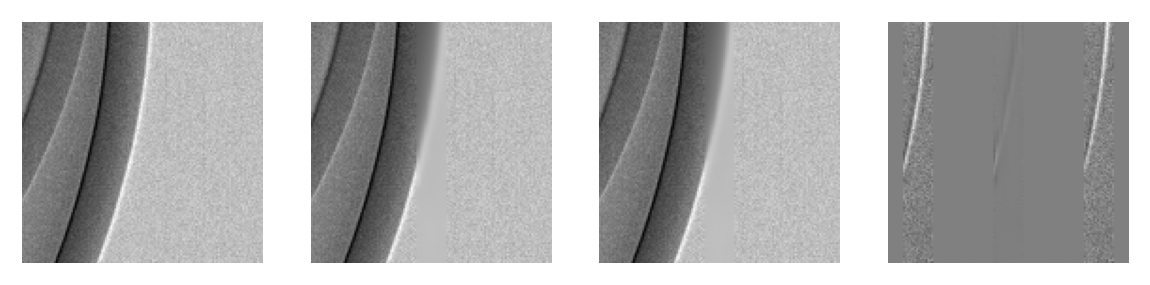

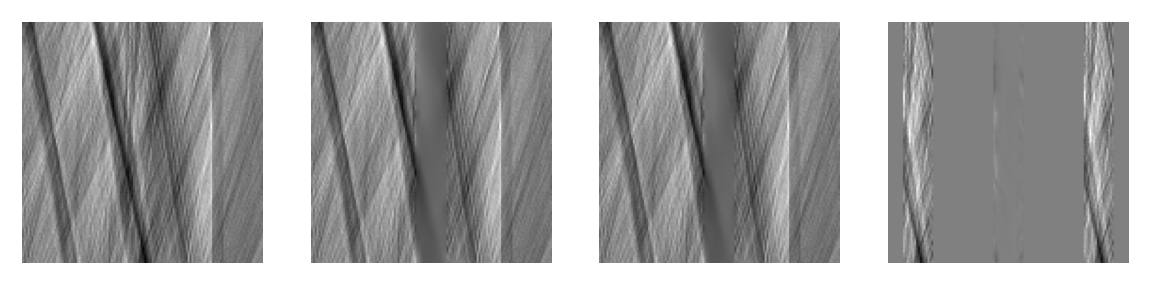

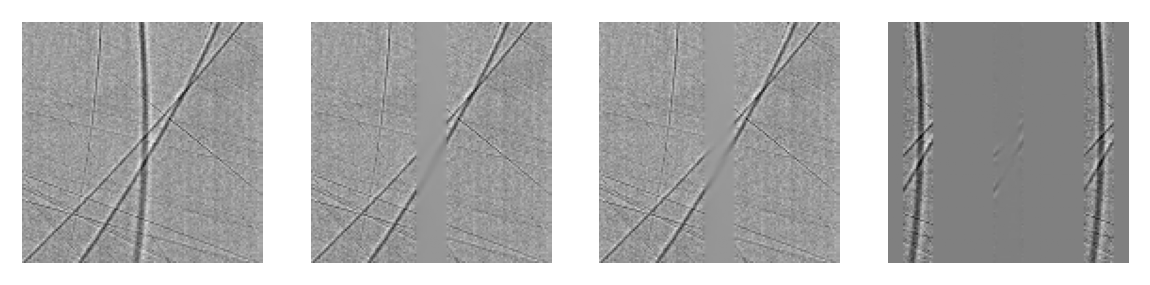

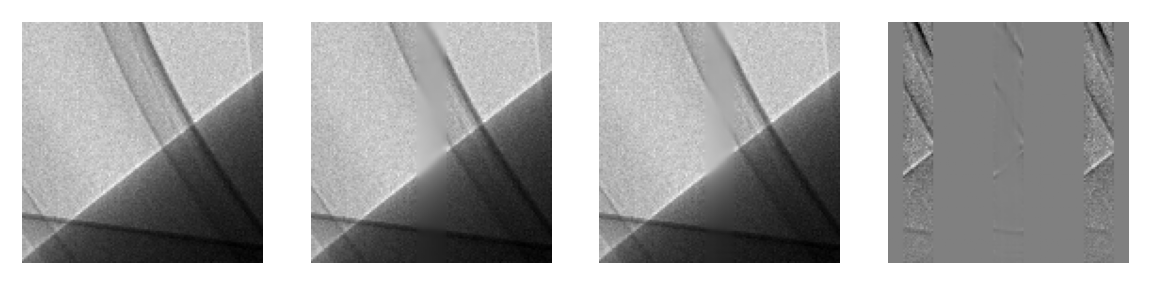

In [122]:
##sg.save_model(sg.generator.lowResGenerator, model_path="tmp3.pt" )
#sg.generator.requires_grad_(False)
#for param in sg.generator.parameters() :
#    #torch.nn.init.normal_(param, mean=1.0, std=0.01)
#    param *= torch.randn_like(param)*0.1 + 1.0
#sg.load_model(sg.generator.lowResGenerator, model_path="tmp3.pt" )

sg.generator.train()
_ = sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

Epoch: 1 (0).  Images: 4352. DIS: 0.000e+00, GEN: 1.530e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: EAGLE: 1.407e+00  MSE: 1.530e+00  MSEN: 1.078e+00  L1L: 2.054e+00  L1LN: 1.040e+00  SSIM: 1.036e+00  MSSSIM: 1.636e+00  STD: 2.028e+00  COR: 1.121e+00  Adv: 1.000e+00 



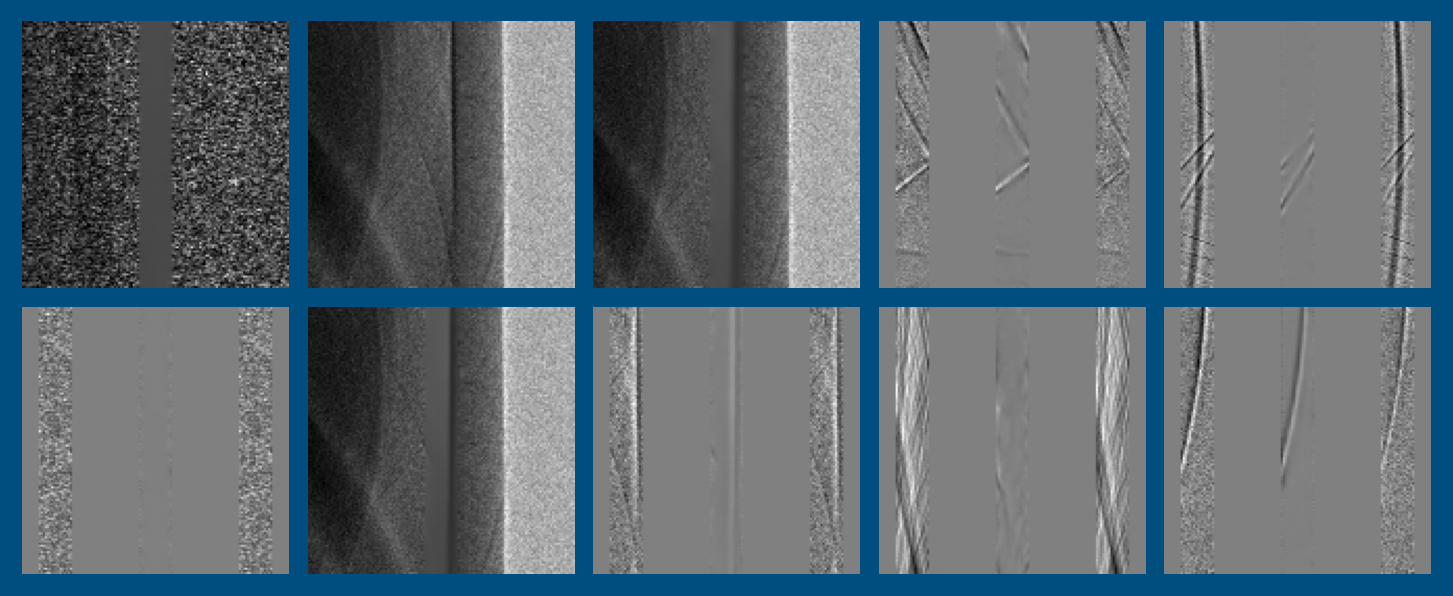

  7%|▋         | 432/6385 [06:30<1:28:25,  1.12it/s]

In [ ]:
sg.freeGPUmem()
sg.freeGPUmem()

#sg.scheduler_G.gamma = 1-0.005
def my_beforeReport(sglocals) :
    #return
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.01)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
    return
#sg.beforeReport = my_beforeReport

def my_beforeEachEpoch(sglocals) :
    sg.TCfg.batchSize = min(2**12, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**8))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.beforeEachEpoch = my_beforeEachEpoch

#sg.TCfg.num_workers=0
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise


# loss MSE raw, BS=2**8, LR=1e-3


## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices_per_epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()